In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import wordcloud

sms = pd.read_csv('E:/Conda/sms-spam/smsspamcollection/SMSSpamCollection', sep='\t', names=['label','message'])
print(sms.shape)

(5572, 2)


In [2]:
sms.drop_duplicates(inplace=True)
sms.reset_index(drop=True, inplace=True)
print(sms.shape)
print(sms[0:10])

(5169, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


In [3]:
sms.label.value_counts()

ham     4516
spam     653
Name: label, dtype: int64

e:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


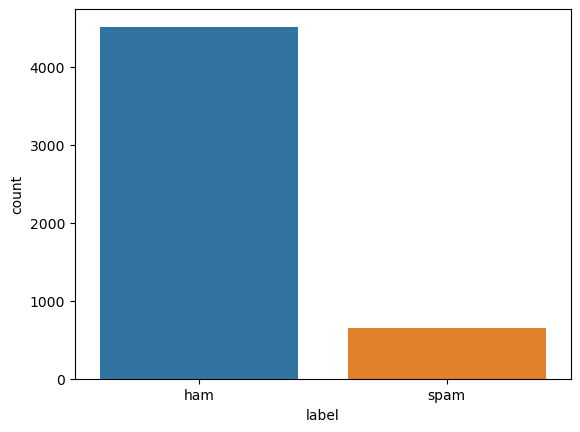

In [4]:
sns.countplot(sms['label'])
plt.savefig("dist")
plt.show()

In [5]:
sms['label'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data_ham = sms[sms['label'] == 0].copy()
data_spam = sms[sms['label'] == 1].copy()

def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, 
        background_color='white', 
        colormap='viridis', 
        width=800, 
        height=600).generate(text)
    plt.figure(figsize=(10,7))
    plt.imshow(fig_wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

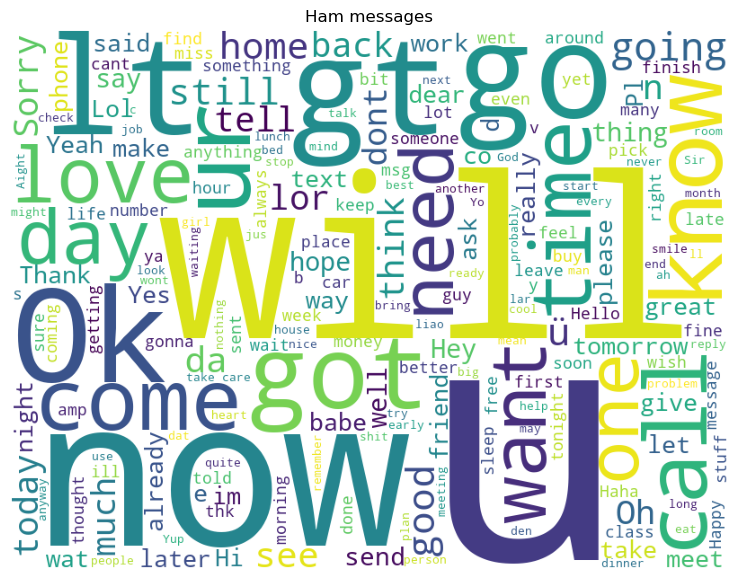

In [7]:
show_wordcloud(data_ham, "Ham messages")

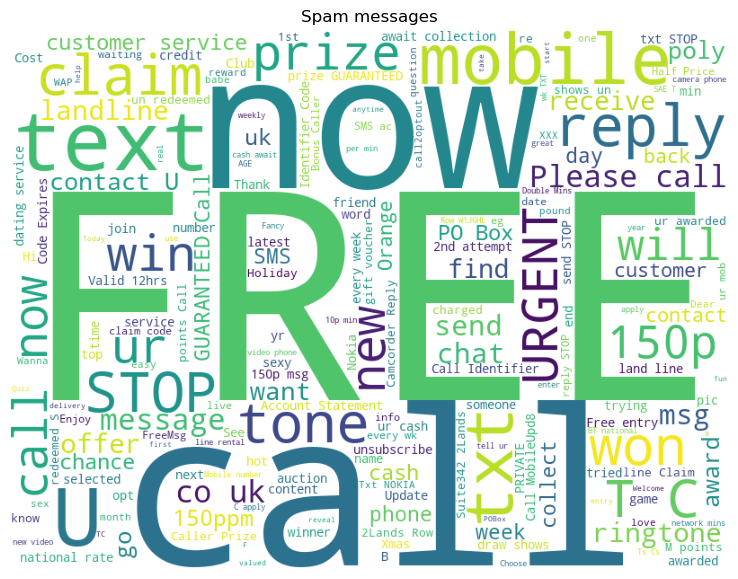

In [8]:
show_wordcloud(data_spam, "Spam messages")

In [9]:
from sklearn.model_selection import train_test_split

X = sms['message'].values
y = sms['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping   

In [11]:
# prepare the tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

In [12]:
# pad documents to a max length
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)

[[  21    2  852 ...   91   10 3504]
 [ 373   60   39 ...  337    0    0]
 [  22   48    2 ... 3505 1035    0]
 ...
 [ 916    1 1209 ...   18    2  152]
 [1757  899  662 ... 3356 1547 7889]
 [1648 1649 1407 ...  591  425   18]]


In [13]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 24)             189360    
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 500)               96500     
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train, 
          y=y_train, 
          epochs=50,
          validation_data=(padded_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/50
130/130 [==============================] - 2s 7ms/step - loss: 0.2228 - accuracy: 0.9151 - val_loss: 0.0998 - val_accuracy: 0.9652
Epoch 2/50
130/130 [==============================] - 1s 5ms/step - loss: 0.0605 - accuracy: 0.9828 - val_loss: 0.0672 - val_accuracy: 0.9710
Epoch 3/50
130/130 [==============================] - 1s 6ms/step - loss: 0.0289 - accuracy: 0.9923 - val_loss: 0.0988 - val_accuracy: 0.9749
Epoch 4/50
130/130 [==============================] - 1s 4ms/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.1039 - val_accuracy: 0.9720
Epoch 5/50
130/130 [==============================] - 1s 4ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.1274 - val_accuracy: 0.9700
Epoch 6/50
130/130 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.1610 - val_accuracy: 0.9710
Epoch 7/50
130/130 [==============================] - 1s 5ms/step - loss: 2.1744e-04 - accuracy: 1.0000 - val_loss: 0.1800 - val_accuracy: 0.9700
Ep

In [15]:
# evaluate the model
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 97.001934


In [16]:
y_pred = (model.predict(padded_test) > 0.5).astype("int32")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report")
print(classification_report(y_test, y_pred))
acc_sc = accuracy_score(y_test, y_pred)
print("Accuracy : "+ str(acc_sc))

33/33 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       896
           1       0.93      0.83      0.88       138

    accuracy                           0.97      1034
   macro avg       0.95      0.91      0.93      1034
weighted avg       0.97      0.97      0.97      1034

Accuracy : 0.9700193423597679
